In [1]:
import pandas as pd

In [2]:
df_b = pd.read_csv('barley_yield_from_1982(in).csv', sep=';')
df_b.drop(columns='Unnamed: 0', inplace=True)
df_b['yield'] = df_b['yield'].fillna(df_b['production'] / df_b['area'])

In [3]:
df_climatic = pd.read_parquet('climate_data_from_1982.parquet')

df_climatic_wide = df_climatic[df_climatic['scenario'] == 'historical'].pivot_table(
    index=['nom_dep', 'year', 'time'],
    columns='metric',
    values='value'
).reset_index()

In [4]:
df_climatic_wide.columns.name = None
df_climatic_wide = df_climatic_wide.rename(columns={
    'nom_dep': 'department',
    'near_surface_air_temperature': 'temp_avg',
    'daily_maximum_near_surface_air_temperature': 'temp_max',
    'precipitation': 'precip'
})
df_climatic_wide['temp_max'] -= 273.15
df_climatic_wide['temp_avg'] -= 273.15
df_climatic_wide['time'] = pd.to_datetime(df_climatic_wide['time'])

In [5]:
import numpy as np

# ---------- 1. 绝对阈值 ----------
HEAT_THRESHOLD = 33   # °C
COLD_THRESHOLD = 0    # °C

# ---------- 2. 准备生长季数据 ----------
df = df_climatic_wide.copy()
df['year']  = df['time'].dt.year
df['month'] = df['time'].dt.month
df_grow = df[df['month'].between(3, 7)].copy()

# ---------- 3. 标记极端事件 ----------
df_grow['is_extreme_heat']  = df_grow['temp_max'] > HEAT_THRESHOLD
df_grow['is_extreme_cold']  = df_grow['temp_max'] < COLD_THRESHOLD
df_grow['is_dry_day']       = df_grow['precip']   < 1.0

# 降水仍用百分位（没有通用绝对阈值）
precip_95 = df_grow.groupby('department')['precip'].quantile(0.95).reset_index()
precip_95.columns = ['department', 'precip_95']
df_grow = df_grow.merge(precip_95, on='department')
df_grow['is_heavy_precip'] = df_grow['precip'] > df_grow['precip_95']

# 强度
df_grow['heat_excess']   = (df_grow['temp_max'] - HEAT_THRESHOLD).clip(lower=0)
df_grow['precip_excess'] = (df_grow['precip']   - df_grow['precip_95']).clip(lower=0)

# ---------- 4. 聚合（变量名不变） ----------
annual_extreme = df_grow.groupby(['department', 'year']).agg(
    n_extreme_heat   = ('is_extreme_heat',  'sum'),
    n_extreme_cold   = ('is_extreme_cold',  'sum'),
    n_heavy_precip   = ('is_heavy_precip',  'sum'),
    n_dry_days       = ('is_dry_day',       'sum'),
    mean_heat_excess = ('heat_excess',      'mean'),
    mean_precip_excess = ('precip_excess',  'mean'),
    temp_avg_grow      = ('temp_avg',       'mean'),
    temp_max_grow      = ('temp_max',       'mean'),
    precip_total_grow  = ('precip',         'sum'),
).reset_index()

print(annual_extreme.head())

  department  year  n_extreme_heat  n_extreme_cold  n_heavy_precip  \
0        Ain  1982               0               1               9   
1        Ain  1983               0               0               9   
2        Ain  1984               0               0               6   
3        Ain  1985               0               0               7   
4        Ain  1986               0               0               7   

   n_dry_days  mean_heat_excess  mean_precip_excess  temp_avg_grow  \
0         153               0.0            0.000006      11.995357   
1         153               0.0            0.000006      11.331988   
2         153               0.0            0.000013      11.959189   
3         153               0.0            0.000007      11.119705   
4         153               0.0            0.000005      11.808128   

   temp_max_grow  precip_total_grow  
0      16.836538           0.012720  
1      16.087030           0.012507  
2      16.997242           0.013384  
3     

In [6]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# ---------- 对每个地区拟合趋势线 ----------
extreme_cols = ['n_extreme_heat', 'n_heavy_precip', 'n_dry_days',
                'mean_heat_excess', 'mean_precip_excess']

trend_results = []

for dept, grp in annual_extreme.groupby('department'):
    grp = grp.sort_values('year')
    X = grp[['year']].values
    for col in extreme_cols:
        y = grp[col].values
        if len(y) < 5:
            continue
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        r2 = model.score(X, y)
        trend_results.append({
            'department': dept,
            'indicator': col,
            'slope_per_year': slope,
            'r2': r2,
            'mean_value': y.mean(),
            # 预测 2030 年的值
            'pred_2030': model.predict([[2030]])[0],
        })

df_trends = pd.DataFrame(trend_results)
print(df_trends[df_trends['indicator'] == 'n_extreme_heat']
      .sort_values('slope_per_year', ascending=False).head(10))

           department       indicator  slope_per_year        r2  mean_value  \
60   Bouches_du_Rhone  n_extreme_heat        0.201537  0.175556    3.484848   
400   Tarn_et_Garonne  n_extreme_heat        0.117313  0.058214    4.333333   
155              Gers  n_extreme_heat        0.116644  0.048780    4.727273   
270    Lot_et_Garonne  n_extreme_heat        0.113636  0.050185    4.939394   
415          Vaucluse  n_extreme_heat        0.106618  0.171563    1.484848   
115          Dordogne  n_extreme_heat        0.077206  0.037425    3.272727   
170     Haute_Garonne  n_extreme_heat        0.071190  0.058348    2.060606   
75           Charente  n_extreme_heat        0.065842  0.028813    3.454545   
240            Landes  n_extreme_heat        0.064840  0.047636    2.757576   
45               Aude  n_extreme_heat        0.063837  0.126054    1.090909   

     pred_2030  
60    9.934046  
400   8.087344  
155   8.459893  
270   8.575758  
415   4.896613  
115   5.743316  
170   4.338

In [7]:
import statsmodels.api as sm
# 选一个确实存在的地区
dept_name = annual_extreme['department'].unique()[0]  # 先拿第一个试试
print(f"Using department: {dept_name}")

dept_data = annual_extreme[annual_extreme['department'] == dept_name].sort_values('year')
print(f"Number of rows: {len(dept_data)}")

# 确认有数据后再跑回归
if len(dept_data) > 2:
    X = sm.add_constant(dept_data['year'])
    y = dept_data['n_extreme_heat']
    
    ols_model = sm.OLS(y, X).fit()
    print(ols_model.summary())
    
    # 预测 + 置信区间
    future_years = pd.DataFrame({'year': [2026, 2027, 2028, 2029, 2030]})
    future_X = sm.add_constant(future_years['year'])
    pred = ols_model.get_prediction(future_X)
    print(pred.summary_frame(alpha=0.05))
else:
    print("数据太少，无法回归")

Using department: Ain
Number of rows: 33
                            OLS Regression Results                            
Dep. Variable:         n_extreme_heat   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.2201
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.642
Time:                        13:21:00   Log-Likelihood:                -44.934
No. Observations:                  33   AIC:                             93.87
Df Residuals:                      31   BIC:                             96.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [8]:
import statsmodels.formula.api as smf

# ---------- 1. 合并产量与气候 ----------
# 先确认 yield 数据的列名，假设有 department / year / yield
df_b_renamed = df_b.rename(columns={'nom_dep': 'department'})  # 按实际列名调整
df_panel = annual_extreme.merge(df_b_renamed[['department', 'year', 'yield']],
                                 on=['department', 'year'], how='inner')
df_panel = df_panel.dropna(subset=['yield'])

# ---------- 2. 面板回归：产量 ~ 气候 + 地区固定效应 ----------
# 加入温度的二次项（作物产量对温度常呈倒 U 型关系）
df_panel['temp_avg_grow_sq'] = df_panel['temp_avg_grow'] ** 2

formula = (
    'Q("yield") ~ temp_avg_grow + temp_avg_grow_sq + precip_total_grow '
    '+ n_extreme_heat + n_dry_days + n_heavy_precip '
    '+ C(department)'
)
model_panel = smf.ols(formula, data=df_panel).fit(cov_type='cluster',
                                                   cov_kwds={'groups': df_panel['department']})
print(model_panel.summary())

                            OLS Regression Results                            
Dep. Variable:             Q("yield")   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     498.4
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           6.09e-63
Time:                        13:21:00   Log-Likelihood:                -3269.3
No. Observations:                2935   AIC:                             6727.
Df Residuals:                    2841   BIC:                             7289.
Df Model:                          93                                         
Covariance Type:              cluster                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

d:\anaconda\envs\deep-seek-crawler\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 94, but rank is 5
  warnings.warn('covariance of constraints does not have full '


In [9]:
# 方法 A：分地区回归
sensitivity_by_dept = []
for dept, grp in df_panel.groupby('department'):
    if len(grp) < 10:
        continue
    grp = grp.copy()
    grp['temp_sq'] = grp['temp_avg_grow'] ** 2
    X = sm.add_constant(grp[['temp_avg_grow', 'temp_sq', 'precip_total_grow',
                              'n_extreme_heat', 'n_dry_days']])
    y = grp['yield']
    try:
        res = sm.OLS(y, X).fit()
        sensitivity_by_dept.append({
            'department': dept,
            'coef_temp': res.params.get('temp_avg_grow', np.nan),
            'coef_extreme_heat': res.params.get('n_extreme_heat', np.nan),
            'coef_precip': res.params.get('precip_total_grow', np.nan),
            'coef_dry_days': res.params.get('n_dry_days', np.nan),
            'r2': res.rsquared,
            'n_obs': len(grp),
        })
    except Exception:
        pass

df_sensitivity = pd.DataFrame(sensitivity_by_dept)
print(df_sensitivity.sort_values('coef_extreme_heat').head(10))

       department  coef_temp  coef_extreme_heat  coef_precip  coef_dry_days  \
18        Correze  -0.942729          -0.545694     8.801749       0.042406   
47           Jura  -2.674828          -0.439099    72.963085       0.097106   
29      Finistere  -3.859385          -0.364224   187.027929       0.149013   
0             Ain  -3.703238          -0.353840    80.282982       0.144536   
69    Puy_de_Dome  -2.586503          -0.343101   105.111514       0.099515   
42        Herault   1.772739          -0.294696    73.601217      -0.087204   
10        Aveyron  -1.611546          -0.289757    29.310165       0.066360   
62       Morbihan  -3.173936          -0.236185   186.189816       0.131337   
20  Cotes_d_Armor  -2.278651          -0.201854    39.407623       0.099255   
33      Haut_Rhin  -1.813238          -0.183534   198.814130       0.074286   

          r2  n_obs  
18  0.227435     33  
47  0.309009     33  
29  0.232486     33  
0   0.361981     33  
69  0.254761     33 

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ============================================================
# STEP 0: Point to your actual dataframes
# ============================================================
df_climate = annual_extreme   # climate indicators by dept × year
df_panel_data = df_panel      # merged climate + yield

# Quick column check
print("df_climate columns:", list(df_climate.columns))
print("df_panel   columns:", list(df_panel_data.columns))
print("df_climate shape:",   df_climate.shape)
print("df_panel   shape:",   df_panel_data.shape)

# Detect yield column
yield_col = None
for candidate in ['yield', 'rendement', 'Yield', 'yield_tha']:
    if candidate in df_panel_data.columns:
        yield_col = candidate
        break
print(f"Yield column detected: '{yield_col}'")

# Significance stars helper
def sig_stars(p):
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    if p < 0.10:  return '†'
    return ''


# ============================================================
# TABLE 1: Climate Change Sensitivity by Department
# ============================================================
climate_trends = []

for dept in df_climate['department'].unique():
    sub = df_climate[df_climate['department'] == dept].sort_values('year')
    n = len(sub)
    if n < 10:
        continue

    row = {'department': dept, 'n_years': n}

    for var, label in [('temp_avg_grow',     'temp_avg'),
                       ('temp_max_grow',     'temp_max'),
                       ('precip_total_grow', 'precip'),
                       ('n_extreme_heat',    'extreme_heat'),
                       ('n_heavy_precip',    'heavy_precip'),
                       ('n_dry_days',        'dry_days')]:
        if var not in sub.columns:
            continue
        valid = sub[['year', var]].dropna()
        if len(valid) < 10:
            continue
        X_var = sm.add_constant(valid['year'].values)
        y_var = valid[var].values
        m = sm.OLS(y_var, X_var).fit()
        row[f'{label}_mean']         = np.mean(y_var)
        row[f'{label}_slope_yr']     = m.params[1]
        row[f'{label}_slope_decade'] = m.params[1] * 10
        row[f'{label}_pvalue']       = m.pvalues[1]
        row[f'{label}_r2']           = m.rsquared

    climate_trends.append(row)

df_climate_trends = pd.DataFrame(climate_trends)

for label in ['temp_avg', 'temp_max', 'precip', 'extreme_heat', 'heavy_precip', 'dry_days']:
    pcol = f'{label}_pvalue'
    if pcol in df_climate_trends.columns:
        df_climate_trends[f'{label}_sig'] = df_climate_trends[pcol].apply(sig_stars)

df_climate_trends = df_climate_trends.sort_values('temp_avg_slope_decade', ascending=False)

print("\n" + "=" * 110)
print("TABLE 1: CLIMATE CHANGE SENSITIVITY BY DEPARTMENT")
print("Linear trend of growing-season climate variables against year  |  Slopes expressed per DECADE")
print("=" * 110)

display1 = ['department', 'n_years',
            'temp_avg_mean',  'temp_avg_slope_decade',  'temp_avg_sig',
            'temp_max_mean',  'temp_max_slope_decade',  'temp_max_sig',
            'precip_mean',    'precip_slope_decade',     'precip_sig',
            'extreme_heat_mean', 'extreme_heat_slope_decade', 'extreme_heat_sig']
existing1 = [c for c in display1 if c in df_climate_trends.columns]
print(df_climate_trends[existing1].round(4).to_string(index=False))

print("\n--- Summary statistics across all departments (per decade) ---")
summ_cols = [c for c in ['temp_avg_slope_decade', 'temp_max_slope_decade',
                          'precip_slope_decade', 'extreme_heat_slope_decade']
             if c in df_climate_trends.columns]
print(df_climate_trends[summ_cols].describe().round(4))

df_climate_trends.to_csv('table1_climate_change_sensitivity.csv', index=False)
print("\nSaved → table1_climate_change_sensitivity.csv")


# ============================================================
# TABLE 2: Yield Sensitivity to Climate by Department
# Model: yield ~ year + temp_avg_grow + precip_total_grow + n_extreme_heat
# ============================================================
yield_sens = []

for dept in df_panel_data['department'].unique():
    required = [yield_col, 'temp_avg_grow', 'precip_total_grow', 'n_extreme_heat', 'year']
    missing = [c for c in required if c not in df_panel_data.columns]
    if missing:
        print(f"WARNING: columns {missing} not in df_panel. Skipping.")
        break

    sub = df_panel_data[df_panel_data['department'] == dept].dropna(subset=required).sort_values('year')
    n = len(sub)
    if n < 10:
        continue

    y = sub[yield_col].values
    X_data = sub[['year', 'temp_avg_grow', 'precip_total_grow', 'n_extreme_heat']].values
    X = sm.add_constant(X_data)
    col_names = ['const', 'year', 'temp_avg_grow', 'precip_total_grow', 'n_extreme_heat']

    try:
        m = sm.OLS(y, X).fit()
        params = dict(zip(col_names, m.params))
        pvals  = dict(zip(col_names, m.pvalues))

        yield_sens.append({
            'department':              dept,
            'n_years':                 n,
            'mean_yield':              np.mean(y),
            'tech_trend_yr':           params['year'],
            'tech_trend_pval':         pvals['year'],
            'coef_temp':               params['temp_avg_grow'],
            'coef_temp_pval':          pvals['temp_avg_grow'],
            'coef_precip':             params['precip_total_grow'],
            'coef_precip_pval':        pvals['precip_total_grow'],
            'coef_extreme_heat':       params['n_extreme_heat'],
            'coef_extreme_heat_pval':  pvals['n_extreme_heat'],
            'r2':                      m.rsquared,
            'adj_r2':                  m.rsquared_adj,
        })
    except Exception as e:
        print(f"  Skipping {dept}: {e}")

df_yield_sens = pd.DataFrame(yield_sens)

for v in ['tech_trend', 'coef_temp', 'coef_precip', 'coef_extreme_heat']:
    pcol = f'{v}_pval'
    if pcol in df_yield_sens.columns:
        df_yield_sens[f'{v}_sig'] = df_yield_sens[pcol].apply(sig_stars)

df_yield_sens = df_yield_sens.sort_values('coef_temp', ascending=True)

print("\n" + "=" * 110)
print("TABLE 2: YIELD SENSITIVITY TO CLIMATE BY DEPARTMENT")
print(f"Model: {yield_col} ~ year + temp_avg_grow + precip_total_grow + n_extreme_heat")
print("'year' controls for technology/management trend; climate coeffs = pure climate sensitivity")
print("=" * 110)

display2 = ['department', 'n_years', 'mean_yield',
            'tech_trend_yr',     'tech_trend_sig',
            'coef_temp',         'coef_temp_sig',
            'coef_precip',       'coef_precip_sig',
            'coef_extreme_heat', 'coef_extreme_heat_sig',
            'adj_r2']
existing2 = [c for c in display2 if c in df_yield_sens.columns]
print(df_yield_sens[existing2].round(4).to_string(index=False))

print("\n--- Summary statistics across all departments ---")
print(df_yield_sens[['coef_temp', 'coef_precip', 'coef_extreme_heat', 'adj_r2']].describe().round(4))

df_yield_sens.to_csv('table2_yield_climate_sensitivity.csv', index=False)
print("\nSaved → table2_yield_climate_sensitivity.csv")


# ============================================================
# TABLE 3 (BONUS): Projected Yield Impact from Climate Change
# Impact per decade = climate_trend_per_decade × yield_sensitivity
# ============================================================
merge_cols_left = ['department']
merge_cols_t1 = ['department', 'temp_avg_slope_decade', 'extreme_heat_slope_decade']
if 'precip_slope_decade' in df_climate_trends.columns:
    merge_cols_t1.append('precip_slope_decade')

merge_cols_t2 = ['department', 'mean_yield', 'coef_temp', 'coef_precip', 'coef_extreme_heat']

df_impact = df_climate_trends[merge_cols_t1].merge(
    df_yield_sens[merge_cols_t2],
    on='department', how='inner'
)

df_impact['impact_temp_decade'] = df_impact['temp_avg_slope_decade'] * df_impact['coef_temp']
df_impact['impact_heat_decade'] = df_impact['extreme_heat_slope_decade'] * df_impact['coef_extreme_heat']

if 'precip_slope_decade' in df_impact.columns:
    df_impact['impact_precip_decade'] = df_impact['precip_slope_decade'] * df_impact['coef_precip']
else:
    df_impact['impact_precip_decade'] = 0.0

df_impact['impact_total_decade'] = (df_impact['impact_temp_decade']
                                  + df_impact['impact_precip_decade']
                                  + df_impact['impact_heat_decade'])
df_impact['impact_pct_decade']   = df_impact['impact_total_decade'] / df_impact['mean_yield'] * 100

df_impact = df_impact.sort_values('impact_total_decade', ascending=True)

print("\n" + "=" * 110)
print("TABLE 3: PROJECTED YIELD IMPACT FROM CLIMATE CHANGE (per decade)")
print("Impact = Climate Trend (per decade) × Yield Sensitivity  |  Negative = yield loss")
print("=" * 110)

display3 = ['department', 'mean_yield',
            'impact_temp_decade', 'impact_precip_decade',
            'impact_heat_decade', 'impact_total_decade',
            'impact_pct_decade']
existing3 = [c for c in display3 if c in df_impact.columns]
print(df_impact[existing3].round(4).to_string(index=False))

print("\n--- 10 Most Vulnerable Departments (largest yield loss per decade) ---")
print(df_impact[existing3].head(10).round(4).to_string(index=False))

print("\n--- 10 Most Resilient Departments (smallest loss or gain per decade) ---")
print(df_impact[existing3].tail(10).round(4).to_string(index=False))

df_impact.to_csv('table3_projected_yield_impact.csv', index=False)
print("\nSaved → table3_projected_yield_impact.csv")

df_climate columns: ['department', 'year', 'n_extreme_heat', 'n_extreme_cold', 'n_heavy_precip', 'n_dry_days', 'mean_heat_excess', 'mean_precip_excess', 'temp_avg_grow', 'temp_max_grow', 'precip_total_grow']
df_panel   columns: ['department', 'year', 'n_extreme_heat', 'n_extreme_cold', 'n_heavy_precip', 'n_dry_days', 'mean_heat_excess', 'mean_precip_excess', 'temp_avg_grow', 'temp_max_grow', 'precip_total_grow', 'yield', 'temp_avg_grow_sq']
df_climate shape: (2937, 11)
df_panel   shape: (2935, 13)
Yield column detected: 'yield'

TABLE 1: CLIMATE CHANGE SENSITIVITY BY DEPARTMENT
Linear trend of growing-season climate variables against year  |  Slopes expressed per DECADE
             department  n_years  temp_avg_mean  temp_avg_slope_decade temp_avg_sig  temp_max_mean  temp_max_slope_decade temp_max_sig  precip_mean  precip_slope_decade precip_sig  extreme_heat_mean  extreme_heat_slope_decade extreme_heat_sig
Alpes_de_Haute_Provence       33         7.6547                 0.5421        

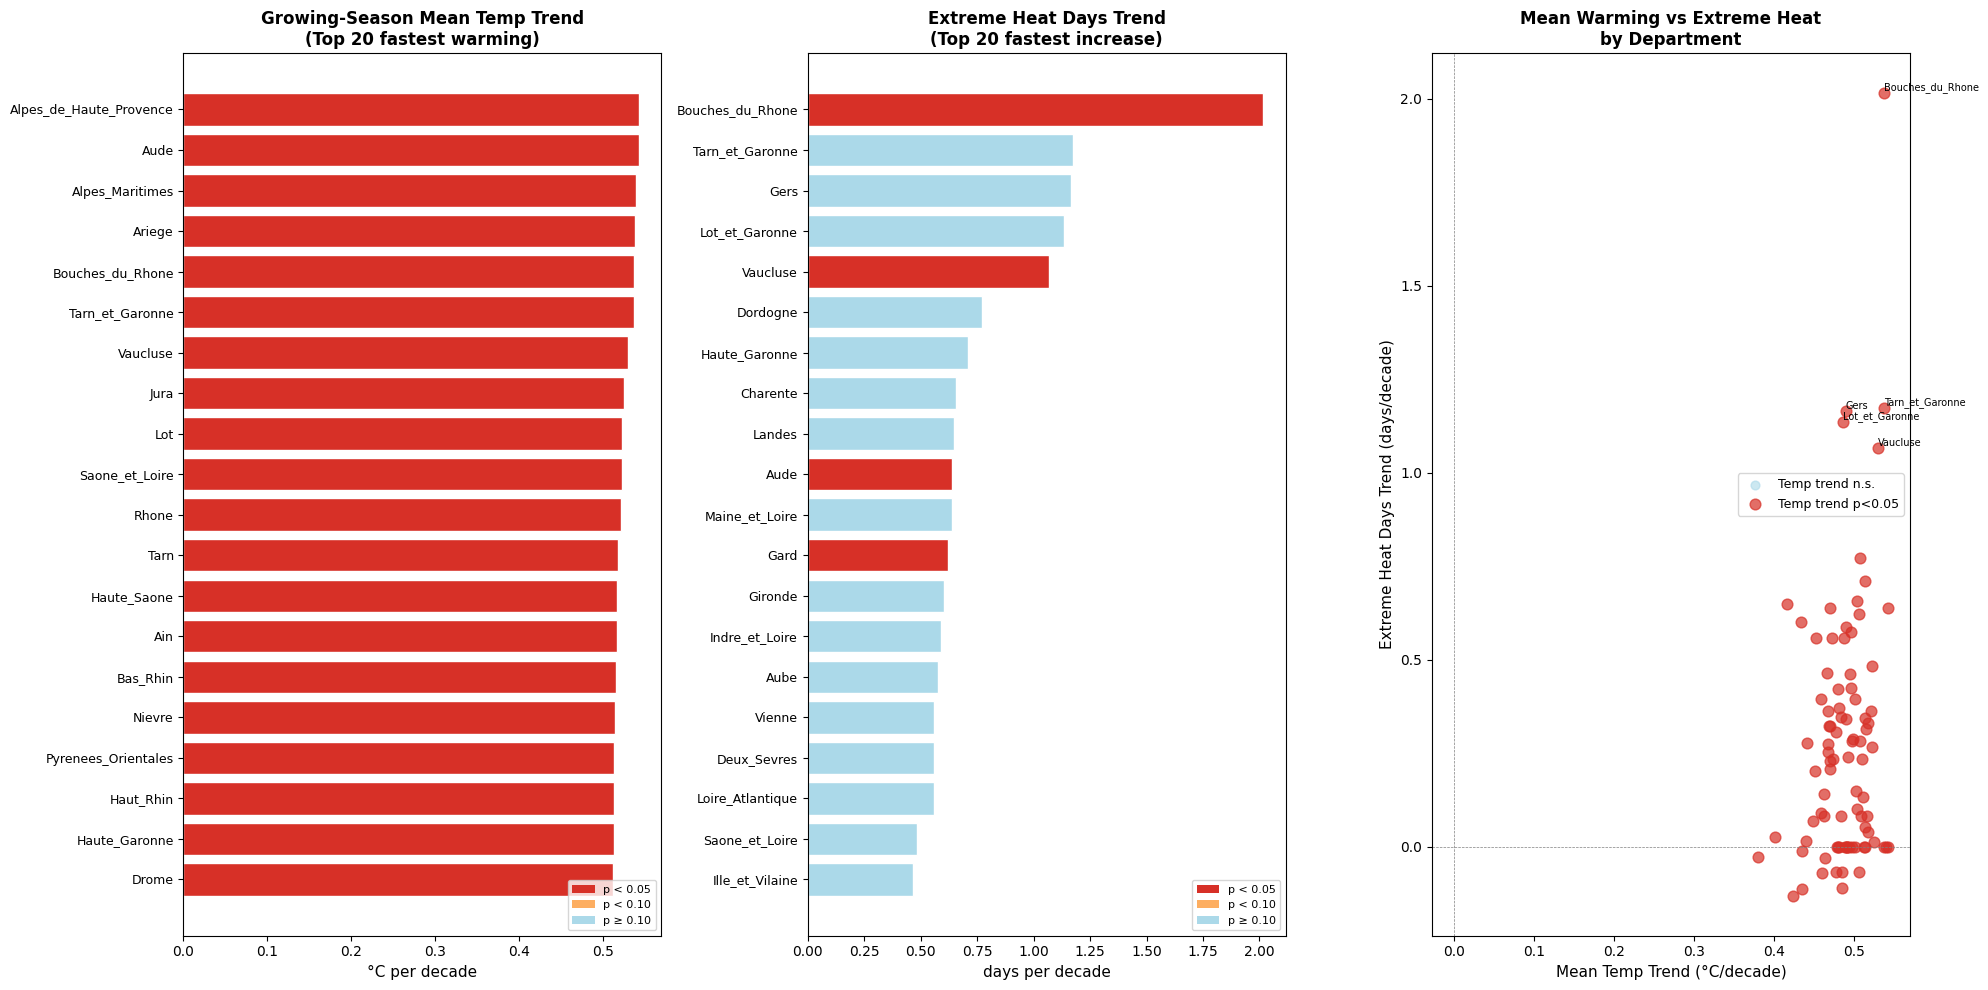

Saved → fig1_climate_sensitivity.png


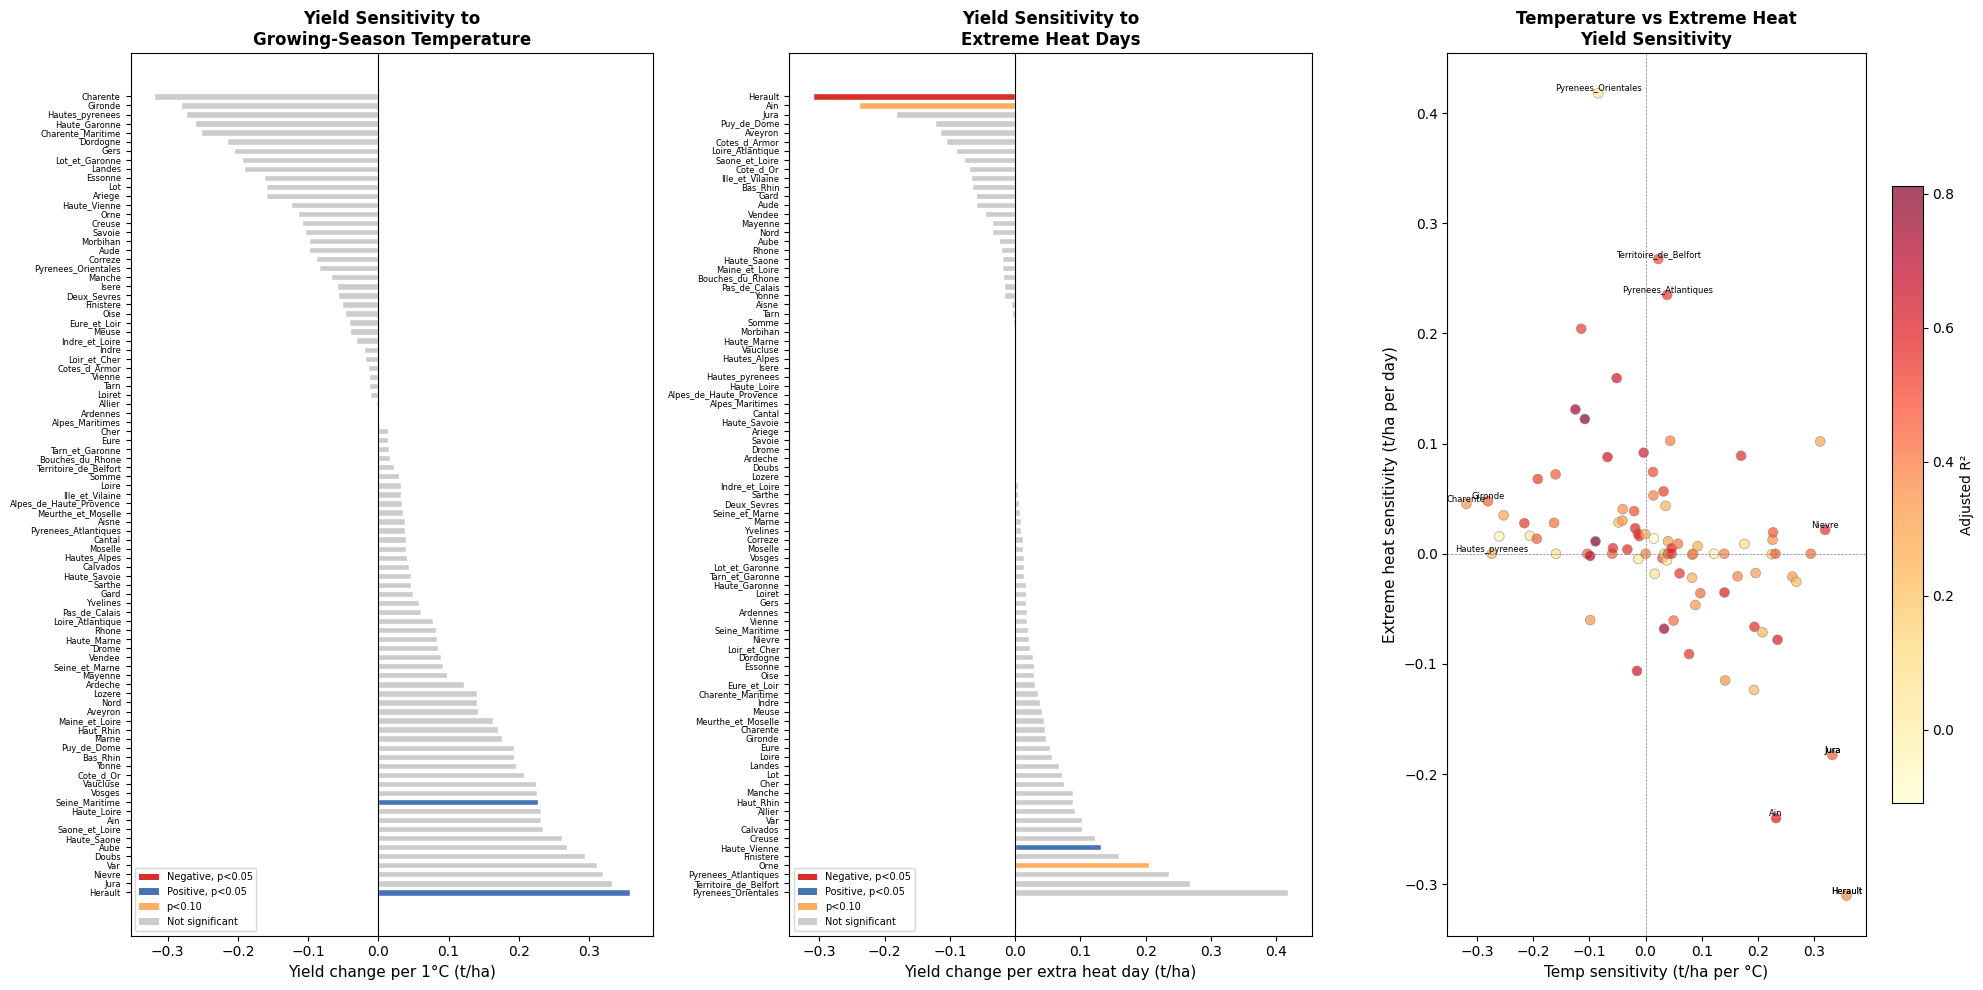

Saved → fig2_yield_sensitivity.png


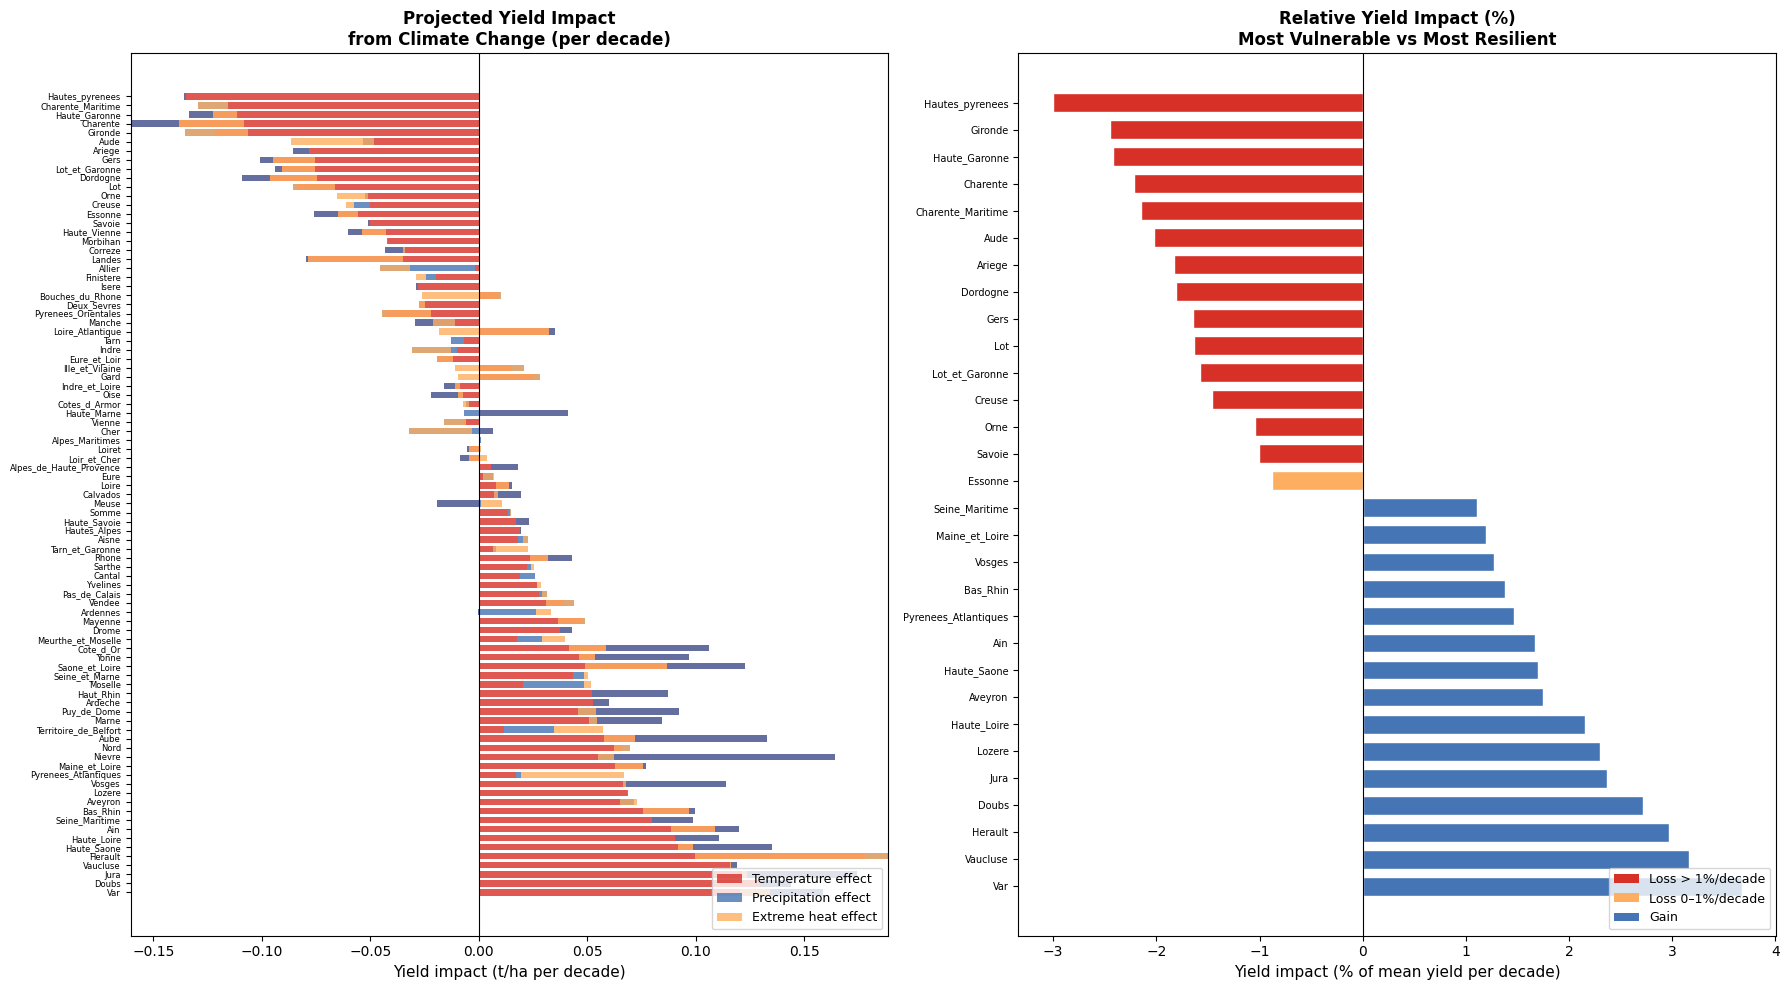

Saved → fig3_projected_yield_impact.png


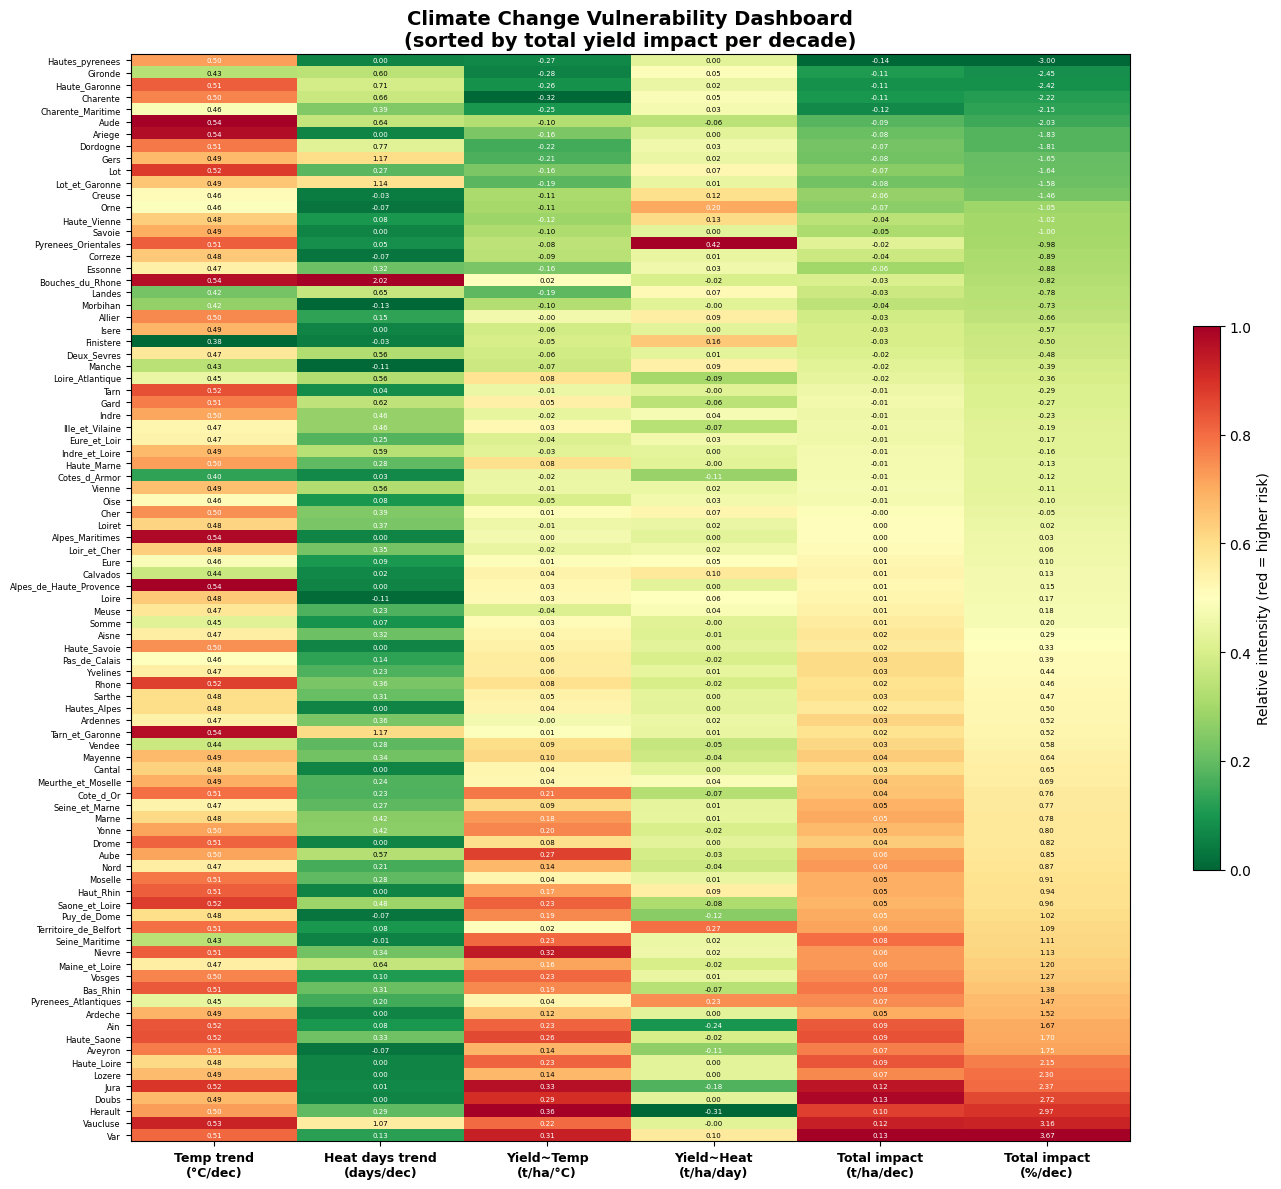

Saved → fig4_vulnerability_heatmap.png


In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# ============================================================
# FIGURE 1: Climate Change Sensitivity
# Top 20 departments by warming rate + extreme heat trend
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# --- 1a: Mean temperature trend (per decade) ---
ax = axes[0]
top20_temp = df_climate_trends.nlargest(20, 'temp_avg_slope_decade')
colors_temp = ['#d73027' if p < 0.05 else '#fdae61' if p < 0.10 else '#abd9e9'
               for p in top20_temp['temp_avg_pvalue']]
ax.barh(range(len(top20_temp)), top20_temp['temp_avg_slope_decade'], color=colors_temp, edgecolor='white')
ax.set_yticks(range(len(top20_temp)))
ax.set_yticklabels(top20_temp['department'], fontsize=9)
ax.set_xlabel('°C per decade', fontsize=11)
ax.set_title('Growing-Season Mean Temp Trend\n(Top 20 fastest warming)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.axvline(x=0, color='black', linewidth=0.5)
# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#d73027', label='p < 0.05'),
                   Patch(facecolor='#fdae61', label='p < 0.10'),
                   Patch(facecolor='#abd9e9', label='p ≥ 0.10')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=8)

# --- 1b: Extreme heat days trend (per decade) ---
ax = axes[1]
top20_heat = df_climate_trends.nlargest(20, 'extreme_heat_slope_decade')
colors_heat = ['#d73027' if p < 0.05 else '#fdae61' if p < 0.10 else '#abd9e9'
               for p in top20_heat['extreme_heat_pvalue']]
ax.barh(range(len(top20_heat)), top20_heat['extreme_heat_slope_decade'], color=colors_heat, edgecolor='white')
ax.set_yticks(range(len(top20_heat)))
ax.set_yticklabels(top20_heat['department'], fontsize=9)
ax.set_xlabel('days per decade', fontsize=11)
ax.set_title('Extreme Heat Days Trend\n(Top 20 fastest increase)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.axvline(x=0, color='black', linewidth=0.5)
ax.legend(handles=legend_elements, loc='lower right', fontsize=8)

# --- 1c: Scatter - temp trend vs extreme heat trend ---
ax = axes[2]
sig_mask = df_climate_trends['temp_avg_pvalue'] < 0.05
ax.scatter(df_climate_trends.loc[~sig_mask, 'temp_avg_slope_decade'],
           df_climate_trends.loc[~sig_mask, 'extreme_heat_slope_decade'],
           c='#abd9e9', alpha=0.6, s=40, label='Temp trend n.s.')
ax.scatter(df_climate_trends.loc[sig_mask, 'temp_avg_slope_decade'],
           df_climate_trends.loc[sig_mask, 'extreme_heat_slope_decade'],
           c='#d73027', alpha=0.7, s=60, label='Temp trend p<0.05')
# Label top 5
top5 = df_climate_trends.nlargest(5, 'extreme_heat_slope_decade')
for _, r in top5.iterrows():
    ax.annotate(r['department'], (r['temp_avg_slope_decade'], r['extreme_heat_slope_decade']),
                fontsize=7, ha='left', va='bottom')
ax.set_xlabel('Mean Temp Trend (°C/decade)', fontsize=11)
ax.set_ylabel('Extreme Heat Days Trend (days/decade)', fontsize=11)
ax.set_title('Mean Warming vs Extreme Heat\nby Department', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.axhline(y=0, color='grey', linewidth=0.5, linestyle='--')
ax.axvline(x=0, color='grey', linewidth=0.5, linestyle='--')

plt.tight_layout()
plt.savefig('fig1_climate_sensitivity.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved → fig1_climate_sensitivity.png")


# ============================================================
# FIGURE 2: Yield Sensitivity to Climate
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# --- 2a: Temperature sensitivity (sorted) ---
ax = axes[0]
df_ys = df_yield_sens.copy()
colors_yt = ['#d73027' if (c < 0 and p < 0.05) else
             '#4575b4' if (c > 0 and p < 0.05) else
             '#fdae61' if p < 0.10 else '#cccccc'
             for c, p in zip(df_ys['coef_temp'], df_ys['coef_temp_pval'])]
ax.barh(range(len(df_ys)), df_ys['coef_temp'], color=colors_yt, edgecolor='white', height=0.7)
ax.set_yticks(range(len(df_ys)))
ax.set_yticklabels(df_ys['department'], fontsize=6)
ax.set_xlabel('Yield change per 1°C (t/ha)', fontsize=11)
ax.set_title('Yield Sensitivity to\nGrowing-Season Temperature', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.invert_yaxis()
legend_yield = [Patch(facecolor='#d73027', label='Negative, p<0.05'),
                Patch(facecolor='#4575b4', label='Positive, p<0.05'),
                Patch(facecolor='#fdae61', label='p<0.10'),
                Patch(facecolor='#cccccc', label='Not significant')]
ax.legend(handles=legend_yield, loc='lower left', fontsize=7)

# --- 2b: Extreme heat sensitivity (sorted) ---
ax = axes[1]
df_ys2 = df_yield_sens.sort_values('coef_extreme_heat', ascending=True)
colors_yh = ['#d73027' if (c < 0 and p < 0.05) else
             '#4575b4' if (c > 0 and p < 0.05) else
             '#fdae61' if p < 0.10 else '#cccccc'
             for c, p in zip(df_ys2['coef_extreme_heat'], df_ys2['coef_extreme_heat_pval'])]
ax.barh(range(len(df_ys2)), df_ys2['coef_extreme_heat'], color=colors_yh, edgecolor='white', height=0.7)
ax.set_yticks(range(len(df_ys2)))
ax.set_yticklabels(df_ys2['department'], fontsize=6)
ax.set_xlabel('Yield change per extra heat day (t/ha)', fontsize=11)
ax.set_title('Yield Sensitivity to\nExtreme Heat Days', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.invert_yaxis()
ax.legend(handles=legend_yield, loc='lower left', fontsize=7)

# --- 2c: Scatter - temp sensitivity vs extreme heat sensitivity ---
ax = axes[2]
ax.scatter(df_yield_sens['coef_temp'], df_yield_sens['coef_extreme_heat'],
           c=df_yield_sens['adj_r2'], cmap='YlOrRd', s=50, alpha=0.7, edgecolors='grey', linewidth=0.5)
cb = plt.colorbar(ax.collections[0], ax=ax, shrink=0.7)
cb.set_label('Adjusted R²', fontsize=10)
# Label extremes
for col, n in [('coef_temp', 3), ('coef_extreme_heat', 3)]:
    extremes = pd.concat([df_yield_sens.nsmallest(n, col), df_yield_sens.nlargest(n, col)]).drop_duplicates()
    for _, r in extremes.iterrows():
        ax.annotate(r['department'], (r['coef_temp'], r['coef_extreme_heat']),
                    fontsize=6, ha='center', va='bottom')
ax.set_xlabel('Temp sensitivity (t/ha per °C)', fontsize=11)
ax.set_ylabel('Extreme heat sensitivity (t/ha per day)', fontsize=11)
ax.set_title('Temperature vs Extreme Heat\nYield Sensitivity', fontsize=12, fontweight='bold')
ax.axhline(y=0, color='grey', linewidth=0.5, linestyle='--')
ax.axvline(x=0, color='grey', linewidth=0.5, linestyle='--')

plt.tight_layout()
plt.savefig('fig2_yield_sensitivity.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved → fig2_yield_sensitivity.png")


# ============================================================
# FIGURE 3: Projected Yield Impact per Decade
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# --- 3a: Stacked bar of impact components (sorted by total) ---
ax = axes[0]
df_imp = df_impact.copy()
y_pos = range(len(df_imp))

ax.barh(y_pos, df_imp['impact_temp_decade'],
        color='#d73027', alpha=0.8, label='Temperature effect', height=0.7)

left = df_imp['impact_temp_decade'].values
if 'impact_precip_decade' in df_imp.columns:
    ax.barh(y_pos, df_imp['impact_precip_decade'],
            left=left, color='#4575b4', alpha=0.8, label='Precipitation effect', height=0.7)
    left = left + df_imp['impact_precip_decade'].values

ax.barh(y_pos, df_imp['impact_heat_decade'],
        left=left, color='#fdae61', alpha=0.8, label='Extreme heat effect', height=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_imp['department'], fontsize=6)
ax.set_xlabel('Yield impact (t/ha per decade)', fontsize=11)
ax.set_title('Projected Yield Impact\nfrom Climate Change (per decade)', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.legend(fontsize=9, loc='lower right')
ax.invert_yaxis()

# --- 3b: Percentage impact (top 15 vulnerable + top 15 resilient) ---
ax = axes[1]
top_vuln = df_imp.head(15)
top_resil = df_imp.tail(15)
df_highlight = pd.concat([top_vuln, top_resil]).drop_duplicates()
df_highlight = df_highlight.sort_values('impact_pct_decade')

colors_pct = ['#d73027' if v < -1 else '#fdae61' if v < 0 else '#4575b4'
              for v in df_highlight['impact_pct_decade']]
ax.barh(range(len(df_highlight)), df_highlight['impact_pct_decade'],
        color=colors_pct, edgecolor='white', height=0.7)
ax.set_yticks(range(len(df_highlight)))
ax.set_yticklabels(df_highlight['department'], fontsize=7)
ax.set_xlabel('Yield impact (% of mean yield per decade)', fontsize=11)
ax.set_title('Relative Yield Impact (%)\nMost Vulnerable vs Most Resilient', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.invert_yaxis()
legend_pct = [Patch(facecolor='#d73027', label='Loss > 1%/decade'),
              Patch(facecolor='#fdae61', label='Loss 0–1%/decade'),
              Patch(facecolor='#4575b4', label='Gain')]
ax.legend(handles=legend_pct, loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig('fig3_projected_yield_impact.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved → fig3_projected_yield_impact.png")


# ============================================================
# FIGURE 4 (BONUS): Summary Heatmap
# ============================================================
fig, ax = plt.subplots(figsize=(14, 12))

# Merge key metrics into one table
df_heatmap = df_climate_trends[['department', 'temp_avg_slope_decade', 'extreme_heat_slope_decade']].merge(
    df_yield_sens[['department', 'coef_temp', 'coef_extreme_heat', 'adj_r2']], on='department'
).merge(
    df_impact[['department', 'impact_total_decade', 'impact_pct_decade']], on='department'
).sort_values('impact_pct_decade')

cols_to_show = ['temp_avg_slope_decade', 'extreme_heat_slope_decade',
                'coef_temp', 'coef_extreme_heat',
                'impact_total_decade', 'impact_pct_decade']
col_labels = ['Temp trend\n(°C/dec)', 'Heat days trend\n(days/dec)',
              'Yield~Temp\n(t/ha/°C)', 'Yield~Heat\n(t/ha/day)',
              'Total impact\n(t/ha/dec)', 'Total impact\n(%/dec)']

data = df_heatmap[cols_to_show].values

# Normalize each column to [0, 1] for color mapping
from matplotlib.colors import Normalize
normed = np.zeros_like(data)
for j in range(data.shape[1]):
    col_data = data[:, j]
    vmin, vmax = np.nanmin(col_data), np.nanmax(col_data)
    if vmax > vmin:
        normed[:, j] = (col_data - vmin) / (vmax - vmin)

im = ax.imshow(normed, aspect='auto', cmap='RdYlGn_r', interpolation='nearest')

ax.set_xticks(range(len(col_labels)))
ax.set_xticklabels(col_labels, fontsize=9, fontweight='bold')
ax.set_yticks(range(len(df_heatmap)))
ax.set_yticklabels(df_heatmap['department'], fontsize=6)

# Annotate cells with actual values
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        text = f'{val:.2f}' if abs(val) < 10 else f'{val:.1f}'
        color = 'white' if normed[i, j] > 0.7 or normed[i, j] < 0.3 else 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=5, color=color)

ax.set_title('Climate Change Vulnerability Dashboard\n(sorted by total yield impact per decade)',
             fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.5, label='Relative intensity (red = higher risk)')
plt.tight_layout()
plt.savefig('fig4_vulnerability_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved → fig4_vulnerability_heatmap.png")

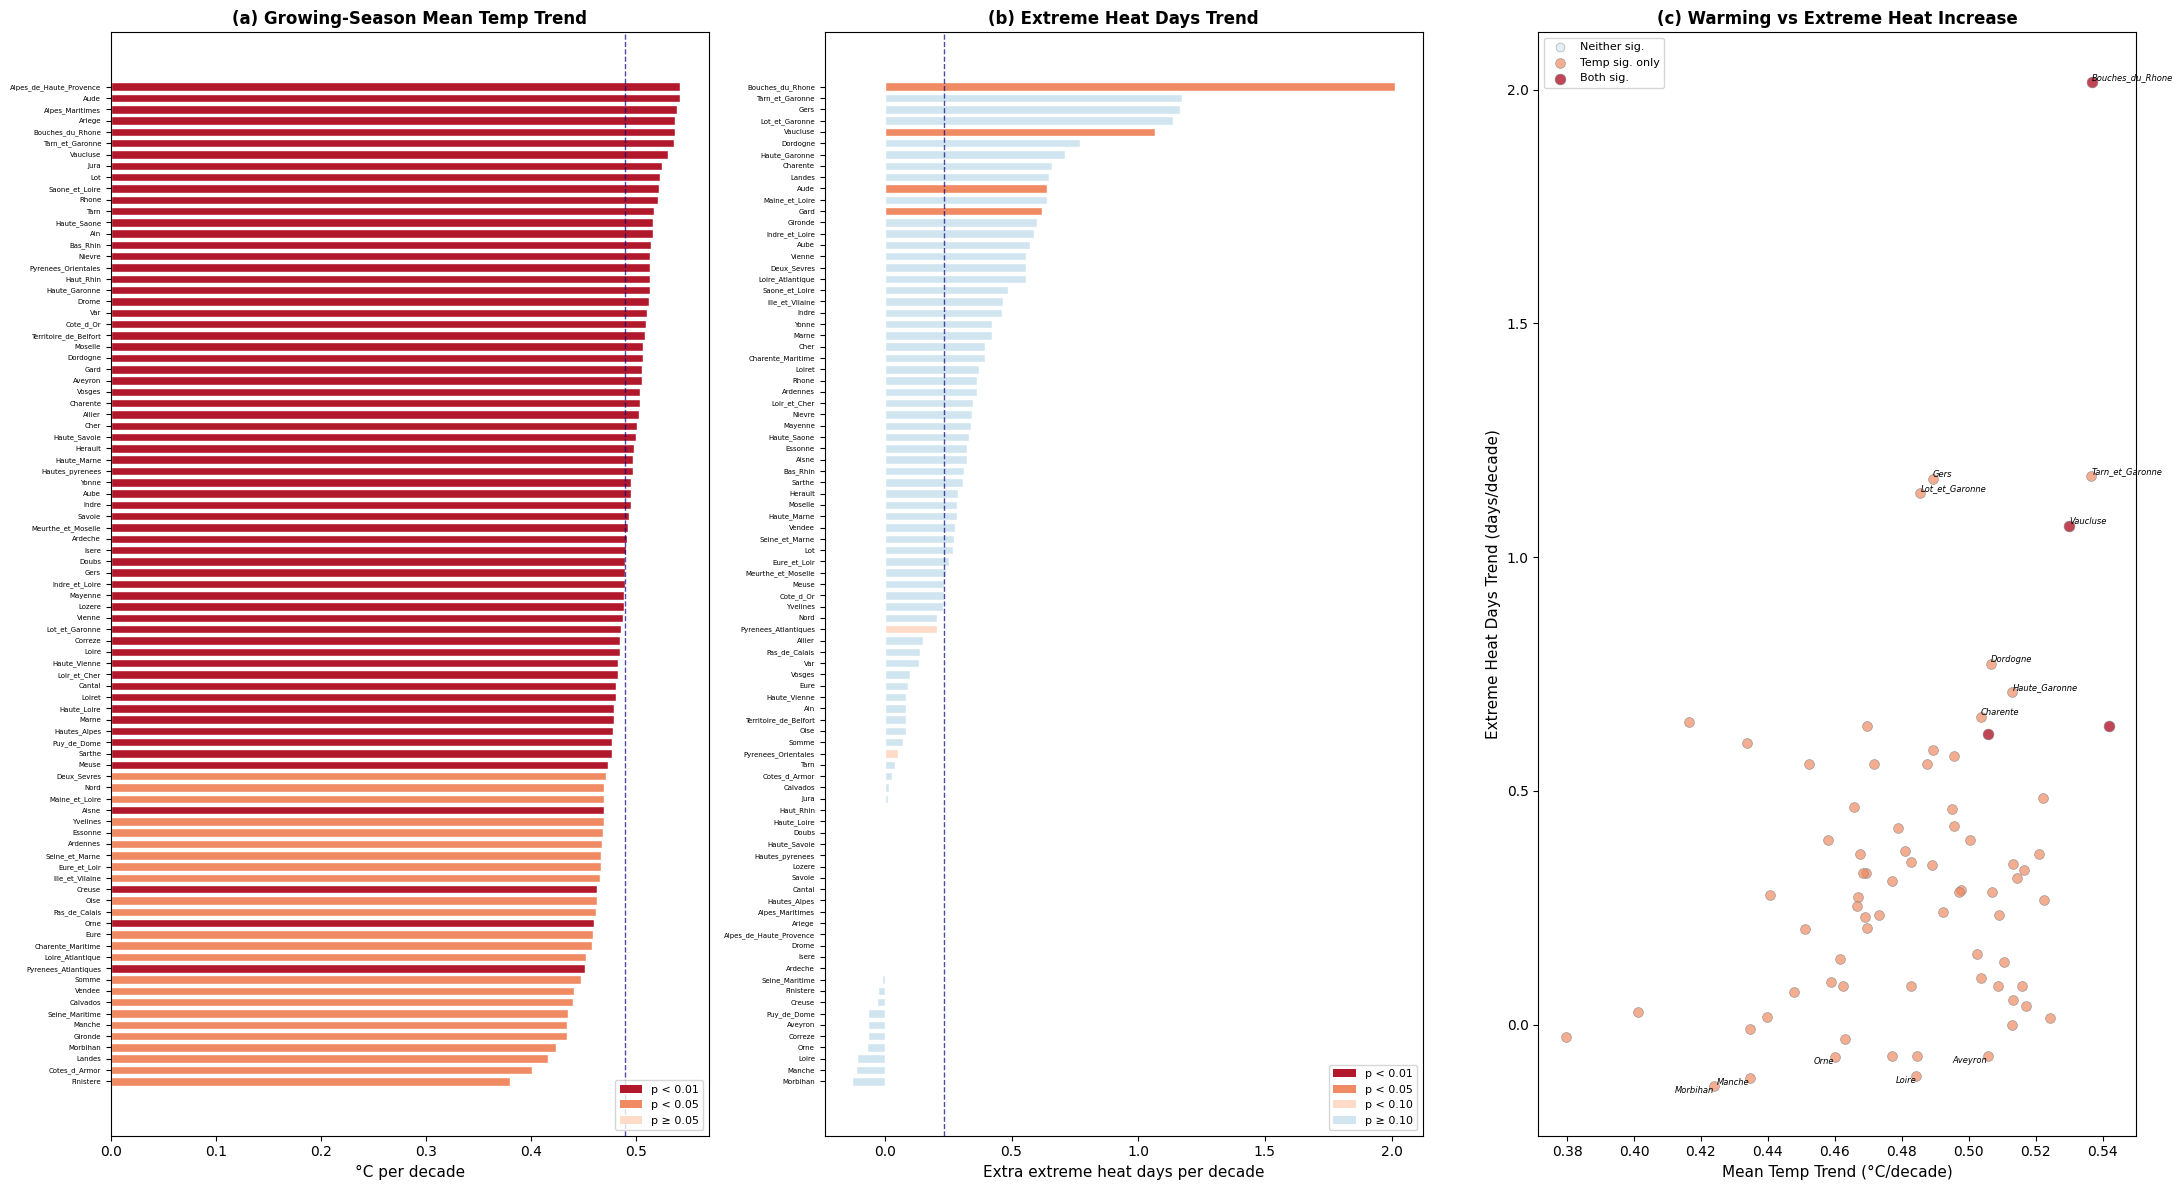

Saved → fig1_climate_sensitivity.png


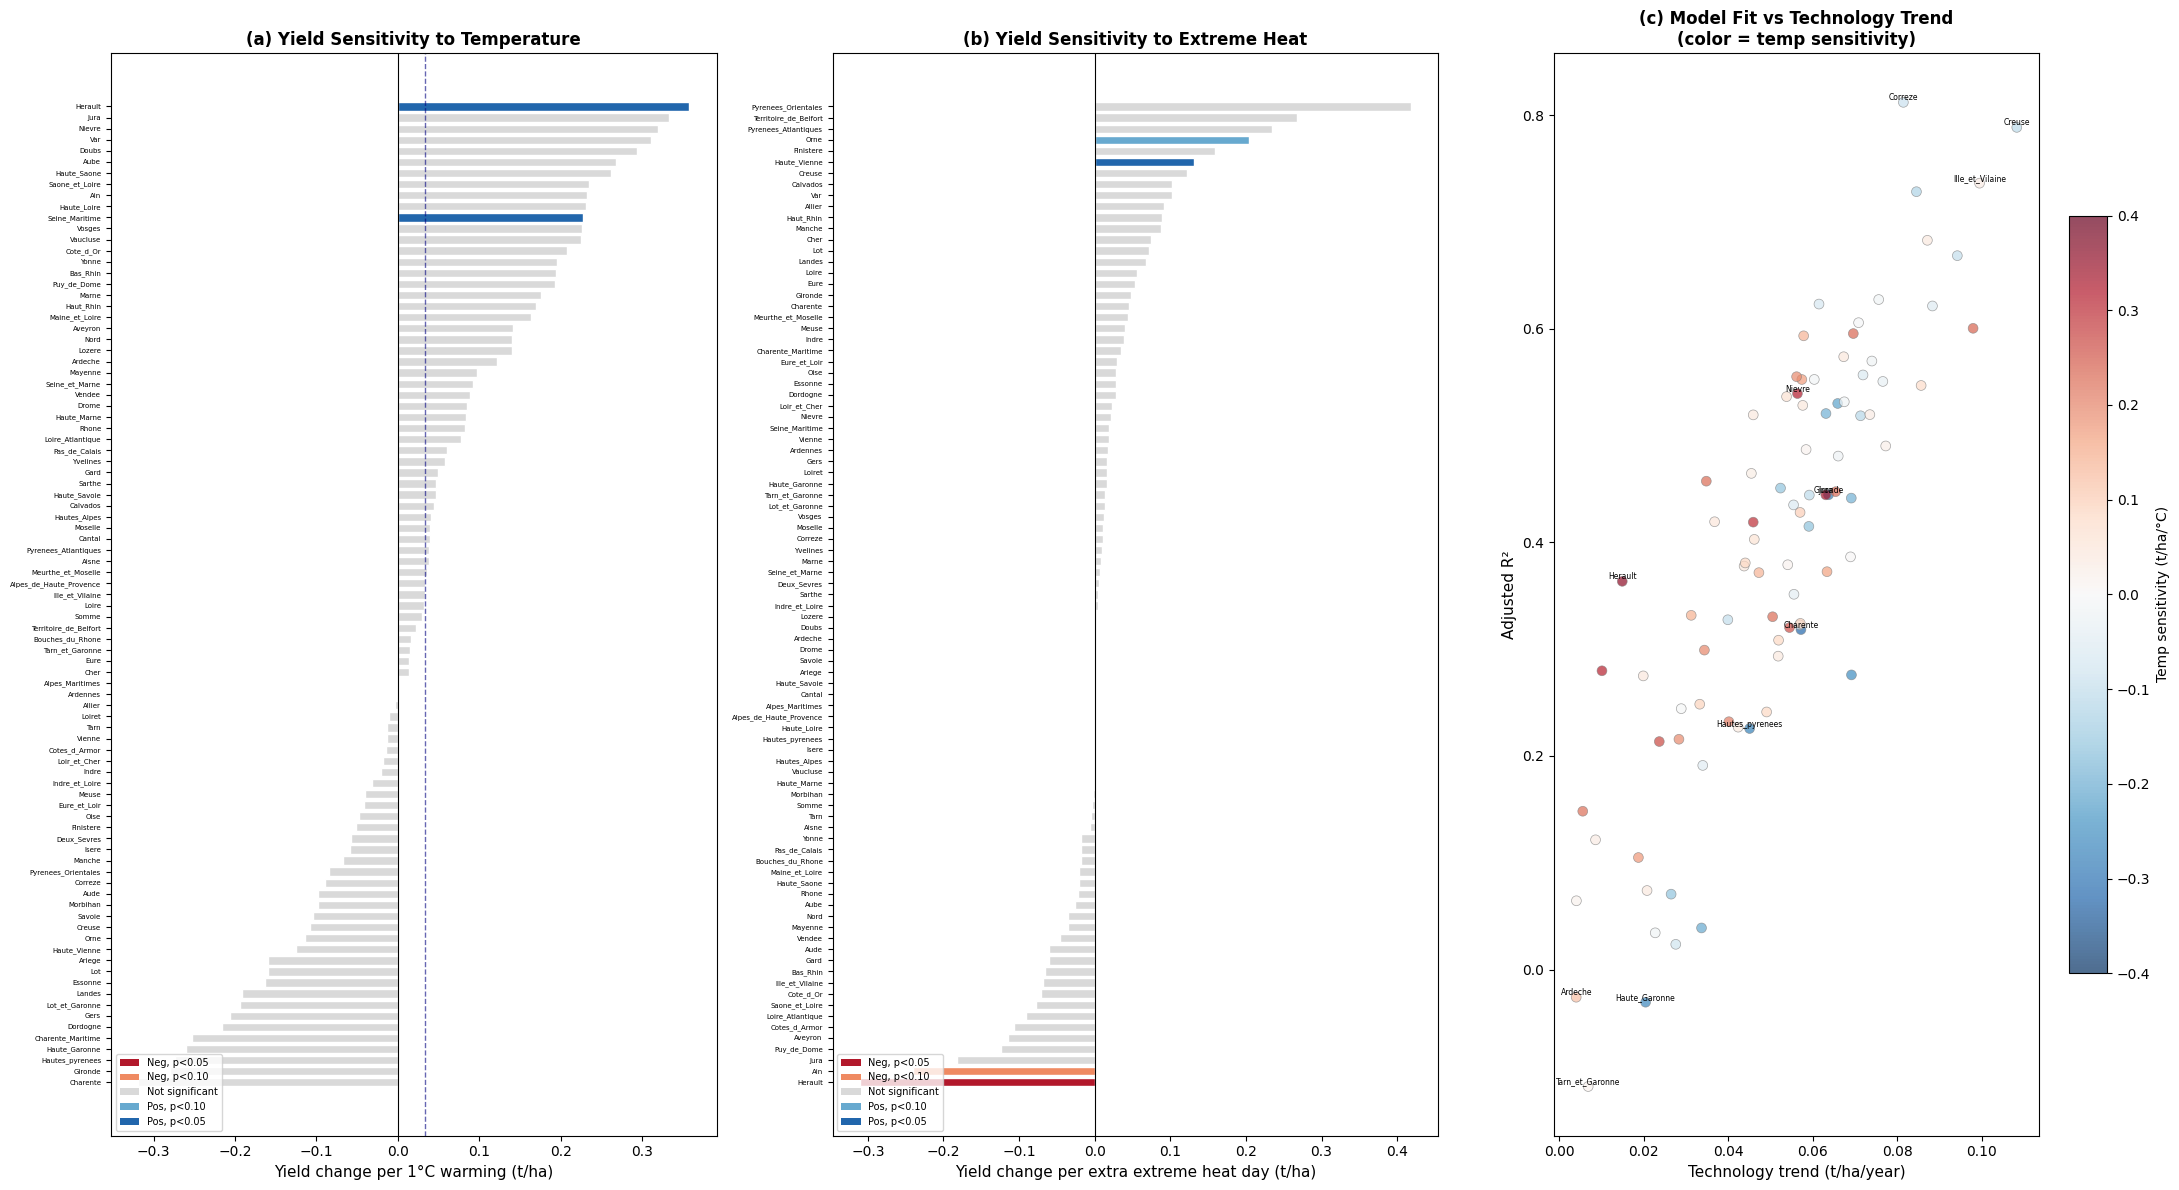

Saved → fig2_yield_sensitivity.png


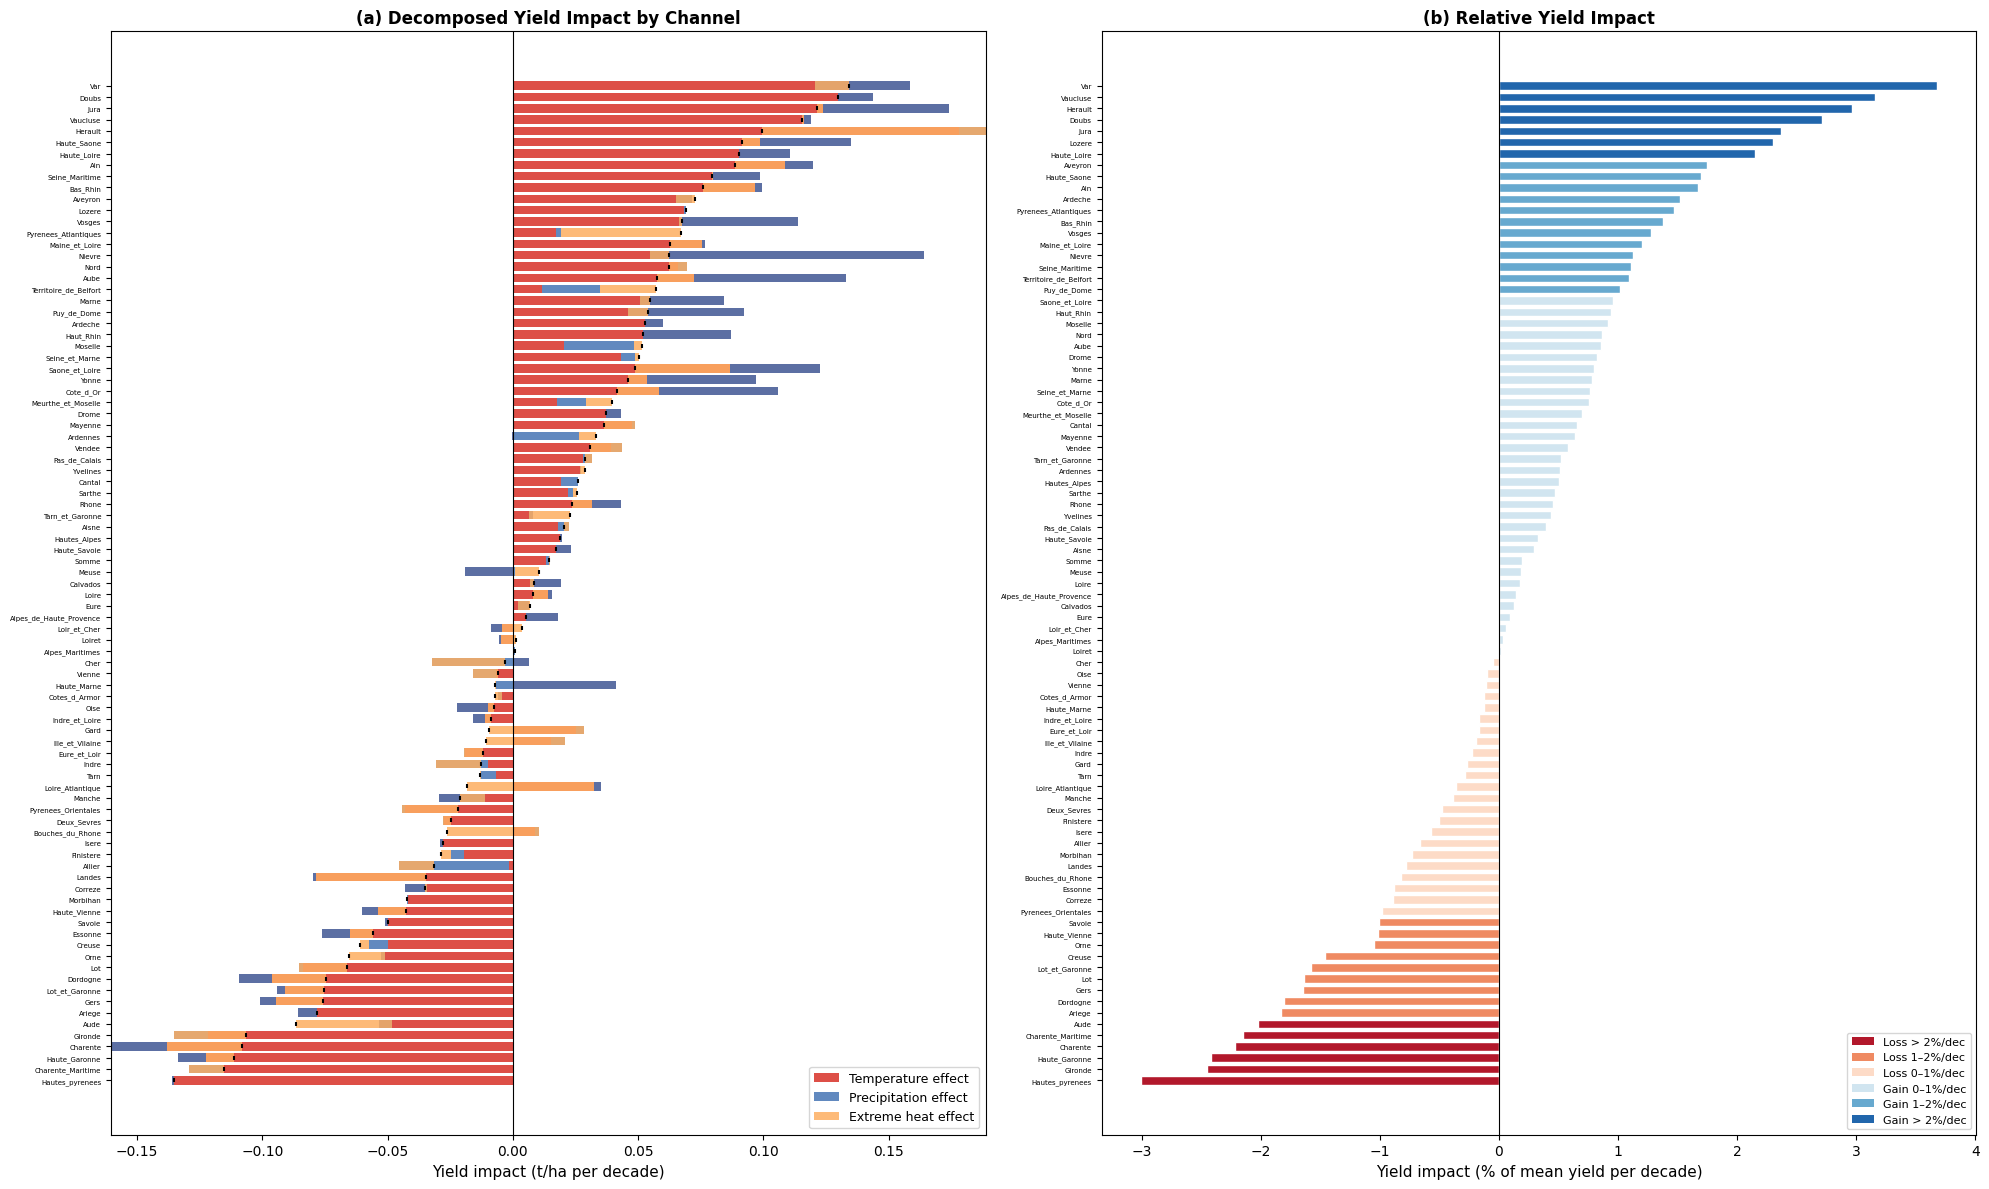

Saved → fig3_projected_impact.png


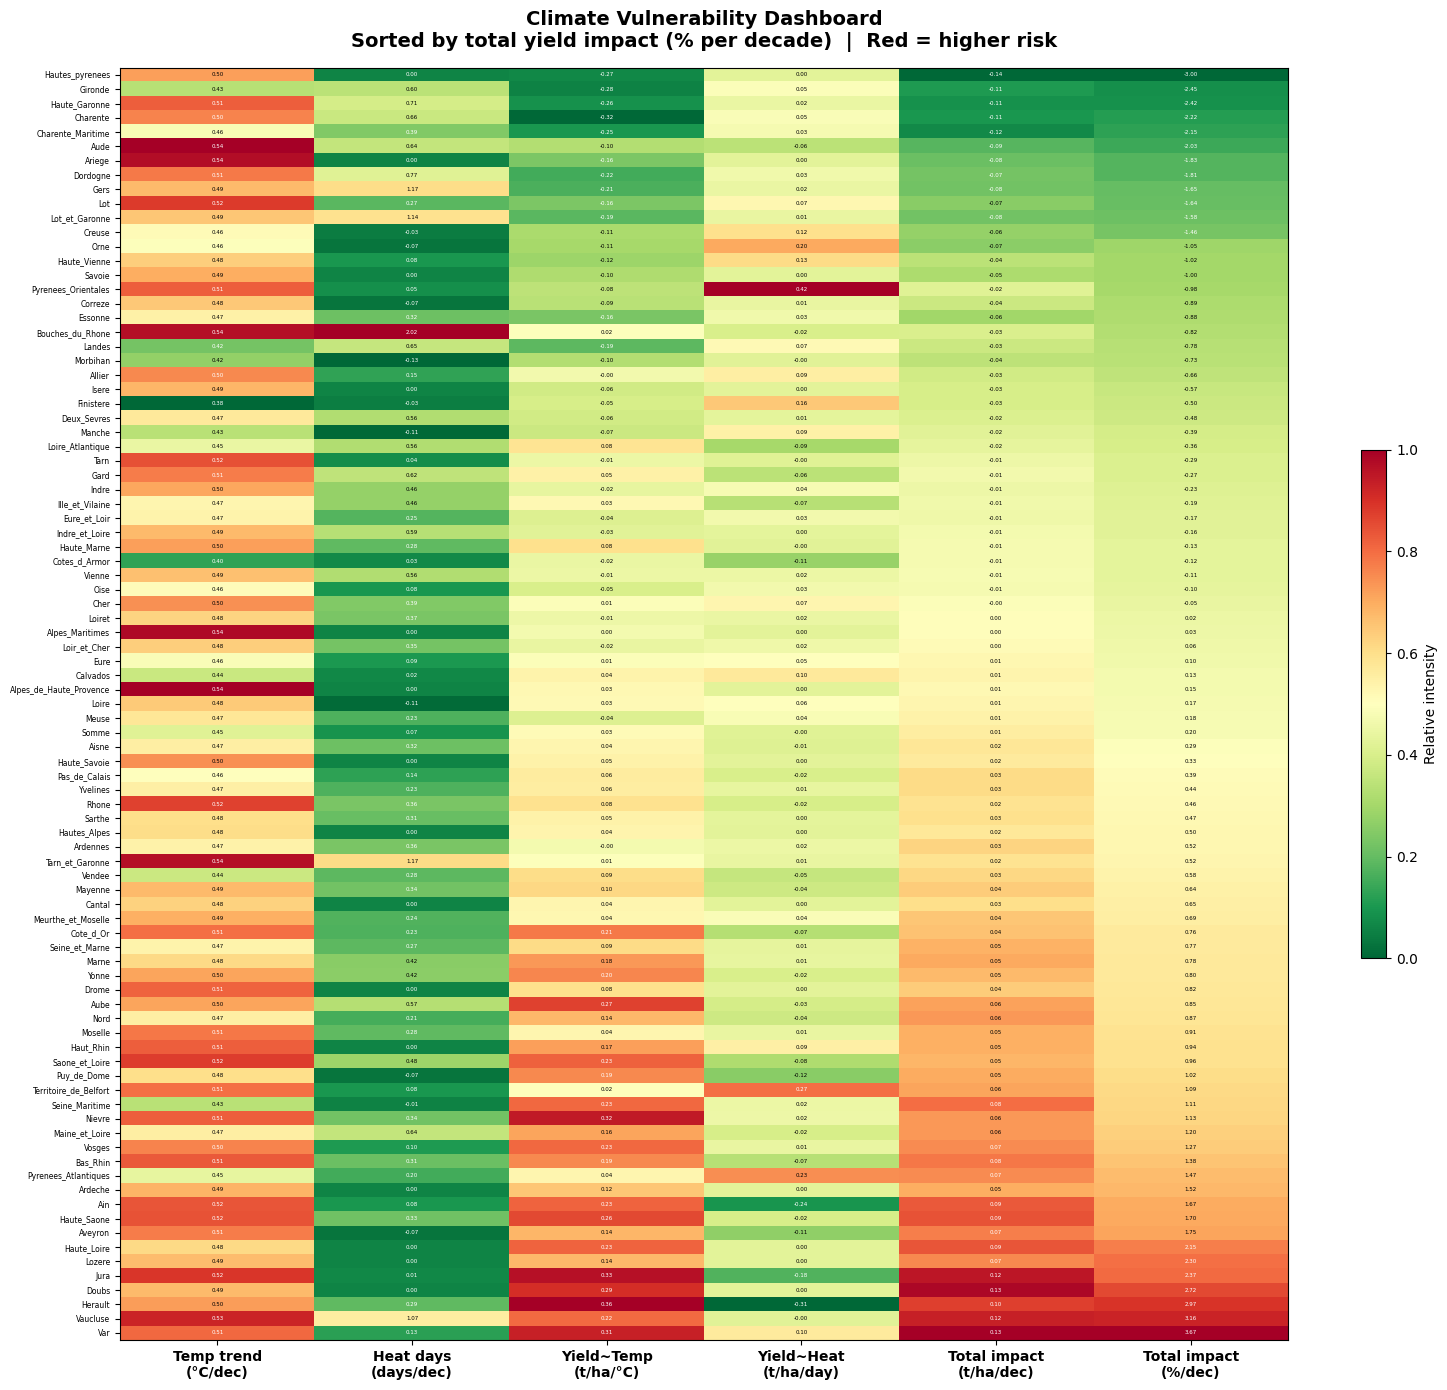

Saved → fig4_heatmap_dashboard.png


In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.patches import Patch

# ============================================================
# FIGURE 1: Climate Change Sensitivity by Department
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(22, 12))

# --- 1a: Mean temperature trend (per decade), all departments ---
ax = axes[0]
df_ct_sorted = df_climate_trends.sort_values('temp_avg_slope_decade', ascending=True)
colors_temp = ['#b2182b' if p < 0.01 else '#ef8a62' if p < 0.05 else '#fddbc7'
               for p in df_ct_sorted['temp_avg_pvalue']]
ax.barh(range(len(df_ct_sorted)), df_ct_sorted['temp_avg_slope_decade'],
        color=colors_temp, edgecolor='white', height=0.75)
ax.set_yticks(range(len(df_ct_sorted)))
ax.set_yticklabels(df_ct_sorted['department'], fontsize=5)
ax.set_xlabel('°C per decade', fontsize=11)
ax.set_title('(a) Growing-Season Mean Temp Trend', fontsize=12, fontweight='bold')
ax.axvline(x=df_climate_trends['temp_avg_slope_decade'].median(), color='navy',
           linewidth=1, linestyle='--', alpha=0.7, label=f"Median: {df_climate_trends['temp_avg_slope_decade'].median():.2f}")
legend1 = [Patch(facecolor='#b2182b', label='p < 0.01'),
           Patch(facecolor='#ef8a62', label='p < 0.05'),
           Patch(facecolor='#fddbc7', label='p ≥ 0.05')]
ax.legend(handles=legend1, loc='lower right', fontsize=8)

# --- 1b: Extreme heat days trend (per decade) ---
ax = axes[1]
df_ct_heat = df_climate_trends.sort_values('extreme_heat_slope_decade', ascending=True)
colors_heat = ['#b2182b' if p < 0.01 else '#ef8a62' if p < 0.05 else
               '#fddbc7' if p < 0.10 else '#d1e5f0'
               for p in df_ct_heat['extreme_heat_pvalue']]
ax.barh(range(len(df_ct_heat)), df_ct_heat['extreme_heat_slope_decade'],
        color=colors_heat, edgecolor='white', height=0.75)
ax.set_yticks(range(len(df_ct_heat)))
ax.set_yticklabels(df_ct_heat['department'], fontsize=5)
ax.set_xlabel('Extra extreme heat days per decade', fontsize=11)
ax.set_title('(b) Extreme Heat Days Trend', fontsize=12, fontweight='bold')
ax.axvline(x=df_climate_trends['extreme_heat_slope_decade'].median(), color='navy',
           linewidth=1, linestyle='--', alpha=0.7)
legend2 = [Patch(facecolor='#b2182b', label='p < 0.01'),
           Patch(facecolor='#ef8a62', label='p < 0.05'),
           Patch(facecolor='#fddbc7', label='p < 0.10'),
           Patch(facecolor='#d1e5f0', label='p ≥ 0.10')]
ax.legend(handles=legend2, loc='lower right', fontsize=8)

# --- 1c: Scatter ---
ax = axes[2]
sig_both = (df_climate_trends['temp_avg_pvalue'] < 0.05) & (df_climate_trends['extreme_heat_pvalue'] < 0.05)
sig_temp = (df_climate_trends['temp_avg_pvalue'] < 0.05) & (df_climate_trends['extreme_heat_pvalue'] >= 0.05)
sig_none = (df_climate_trends['temp_avg_pvalue'] >= 0.05)

ax.scatter(df_climate_trends.loc[sig_none, 'temp_avg_slope_decade'],
           df_climate_trends.loc[sig_none, 'extreme_heat_slope_decade'],
           c='#d1e5f0', s=40, alpha=0.6, label='Neither sig.', edgecolors='grey', linewidth=0.5)
ax.scatter(df_climate_trends.loc[sig_temp, 'temp_avg_slope_decade'],
           df_climate_trends.loc[sig_temp, 'extreme_heat_slope_decade'],
           c='#ef8a62', s=50, alpha=0.7, label='Temp sig. only', edgecolors='grey', linewidth=0.5)
ax.scatter(df_climate_trends.loc[sig_both, 'temp_avg_slope_decade'],
           df_climate_trends.loc[sig_both, 'extreme_heat_slope_decade'],
           c='#b2182b', s=60, alpha=0.8, label='Both sig.', edgecolors='grey', linewidth=0.5)

# Label top 8 extreme heat
top8 = df_climate_trends.nlargest(8, 'extreme_heat_slope_decade')
for _, r in top8.iterrows():
    ax.annotate(r['department'], (r['temp_avg_slope_decade'], r['extreme_heat_slope_decade']),
                fontsize=6, ha='left', va='bottom', fontstyle='italic')
# Label bottom 5
bot5 = df_climate_trends.nsmallest(5, 'extreme_heat_slope_decade')
for _, r in bot5.iterrows():
    ax.annotate(r['department'], (r['temp_avg_slope_decade'], r['extreme_heat_slope_decade']),
                fontsize=6, ha='right', va='top', fontstyle='italic')

ax.set_xlabel('Mean Temp Trend (°C/decade)', fontsize=11)
ax.set_ylabel('Extreme Heat Days Trend (days/decade)', fontsize=11)
ax.set_title('(c) Warming vs Extreme Heat Increase', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='upper left')

plt.tight_layout()
plt.savefig('fig1_climate_sensitivity.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved → fig1_climate_sensitivity.png")


# ============================================================
# FIGURE 2: Yield Sensitivity to Climate
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(22, 12))

# --- 2a: Temperature sensitivity ---
ax = axes[0]
df_ys = df_yield_sens.sort_values('coef_temp', ascending=True)
colors_yt = ['#b2182b' if (c < 0 and p < 0.05) else
             '#ef8a62' if (c < 0 and p < 0.10) else
             '#2166ac' if (c > 0 and p < 0.05) else
             '#67a9cf' if (c > 0 and p < 0.10) else
             '#d9d9d9'
             for c, p in zip(df_ys['coef_temp'], df_ys['coef_temp_pval'])]
ax.barh(range(len(df_ys)), df_ys['coef_temp'], color=colors_yt, edgecolor='white', height=0.75)
ax.set_yticks(range(len(df_ys)))
ax.set_yticklabels(df_ys['department'], fontsize=5)
ax.set_xlabel('Yield change per 1°C warming (t/ha)', fontsize=11)
ax.set_title('(a) Yield Sensitivity to Temperature', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.axvline(x=df_yield_sens['coef_temp'].median(), color='navy', linewidth=1,
           linestyle='--', alpha=0.6, label=f"Median: {df_yield_sens['coef_temp'].median():.3f}")
legend_y = [Patch(facecolor='#b2182b', label='Neg, p<0.05'),
            Patch(facecolor='#ef8a62', label='Neg, p<0.10'),
            Patch(facecolor='#d9d9d9', label='Not significant'),
            Patch(facecolor='#67a9cf', label='Pos, p<0.10'),
            Patch(facecolor='#2166ac', label='Pos, p<0.05')]
ax.legend(handles=legend_y, loc='lower left', fontsize=7)

# --- 2b: Extreme heat sensitivity ---
ax = axes[1]
df_ys2 = df_yield_sens.sort_values('coef_extreme_heat', ascending=True)
colors_yh = ['#b2182b' if (c < 0 and p < 0.05) else
             '#ef8a62' if (c < 0 and p < 0.10) else
             '#2166ac' if (c > 0 and p < 0.05) else
             '#67a9cf' if (c > 0 and p < 0.10) else
             '#d9d9d9'
             for c, p in zip(df_ys2['coef_extreme_heat'], df_ys2['coef_extreme_heat_pval'])]
ax.barh(range(len(df_ys2)), df_ys2['coef_extreme_heat'], color=colors_yh, edgecolor='white', height=0.75)
ax.set_yticks(range(len(df_ys2)))
ax.set_yticklabels(df_ys2['department'], fontsize=5)
ax.set_xlabel('Yield change per extra extreme heat day (t/ha)', fontsize=11)
ax.set_title('(b) Yield Sensitivity to Extreme Heat', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.legend(handles=legend_y, loc='lower left', fontsize=7)

# --- 2c: Technology trend vs adj R² ---
ax = axes[2]
sc = ax.scatter(df_yield_sens['tech_trend_yr'], df_yield_sens['adj_r2'],
                c=df_yield_sens['coef_temp'], cmap='RdBu_r', s=50,
                alpha=0.7, edgecolors='grey', linewidth=0.5,
                vmin=-0.4, vmax=0.4)
cb = plt.colorbar(sc, ax=ax, shrink=0.7)
cb.set_label('Temp sensitivity (t/ha/°C)', fontsize=10)

# Label extreme points
for col in ['adj_r2', 'coef_temp']:
    extremes = pd.concat([df_yield_sens.nsmallest(3, col),
                          df_yield_sens.nlargest(3, col)]).drop_duplicates('department')
    for _, r in extremes.iterrows():
        ax.annotate(r['department'], (r['tech_trend_yr'], r['adj_r2']),
                    fontsize=5.5, ha='center', va='bottom')

ax.set_xlabel('Technology trend (t/ha/year)', fontsize=11)
ax.set_ylabel('Adjusted R²', fontsize=11)
ax.set_title('(c) Model Fit vs Technology Trend\n(color = temp sensitivity)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('fig2_yield_sensitivity.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved → fig2_yield_sensitivity.png")


# ============================================================
# FIGURE 3: Projected Yield Impact
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# --- 3a: Stacked horizontal bar ---
ax = axes[0]
df_imp = df_impact.sort_values('impact_total_decade', ascending=True)

# We need to handle positive and negative stacking carefully
ax.barh(range(len(df_imp)), df_imp['impact_temp_decade'],
        color='#d73027', alpha=0.85, label='Temperature effect', height=0.75)

# For precipitation, stack on the same side
left_precip = df_imp['impact_temp_decade'].values.copy()
ax.barh(range(len(df_imp)), df_imp['impact_precip_decade'],
        left=left_precip, color='#4575b4', alpha=0.85, label='Precipitation effect', height=0.75)

left_heat = left_precip + df_imp['impact_precip_decade'].values
ax.barh(range(len(df_imp)), df_imp['impact_heat_decade'],
        left=left_heat, color='#fdae61', alpha=0.85, label='Extreme heat effect', height=0.75)

# Total marker
ax.scatter(df_imp['impact_total_decade'], range(len(df_imp)),
           color='black', s=12, zorder=5, marker='|', linewidths=1.5)

ax.set_yticks(range(len(df_imp)))
ax.set_yticklabels(df_imp['department'], fontsize=5)
ax.set_xlabel('Yield impact (t/ha per decade)', fontsize=11)
ax.set_title('(a) Decomposed Yield Impact by Channel', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.legend(fontsize=9, loc='lower right')

# --- 3b: Percentage impact, color-coded ---
ax = axes[1]
df_imp_pct = df_impact.sort_values('impact_pct_decade', ascending=True)
colors_pct = ['#b2182b' if v < -2 else '#ef8a62' if v < -1 else
              '#fddbc7' if v < 0 else '#d1e5f0' if v < 1 else
              '#67a9cf' if v < 2 else '#2166ac'
              for v in df_imp_pct['impact_pct_decade']]
ax.barh(range(len(df_imp_pct)), df_imp_pct['impact_pct_decade'],
        color=colors_pct, edgecolor='white', height=0.75)
ax.set_yticks(range(len(df_imp_pct)))
ax.set_yticklabels(df_imp_pct['department'], fontsize=5)
ax.set_xlabel('Yield impact (% of mean yield per decade)', fontsize=11)
ax.set_title('(b) Relative Yield Impact', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
legend_pct = [Patch(facecolor='#b2182b', label='Loss > 2%/dec'),
              Patch(facecolor='#ef8a62', label='Loss 1–2%/dec'),
              Patch(facecolor='#fddbc7', label='Loss 0–1%/dec'),
              Patch(facecolor='#d1e5f0', label='Gain 0–1%/dec'),
              Patch(facecolor='#67a9cf', label='Gain 1–2%/dec'),
              Patch(facecolor='#2166ac', label='Gain > 2%/dec')]
ax.legend(handles=legend_pct, loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig('fig3_projected_impact.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved → fig3_projected_impact.png")


# ============================================================
# FIGURE 4: Summary Heatmap — Vulnerability Dashboard
# ============================================================
fig, ax = plt.subplots(figsize=(16, 14))

df_hm = df_climate_trends[['department', 'temp_avg_slope_decade', 'extreme_heat_slope_decade']].merge(
    df_yield_sens[['department', 'coef_temp', 'coef_extreme_heat', 'adj_r2']], on='department'
).merge(
    df_impact[['department', 'impact_total_decade', 'impact_pct_decade']], on='department'
).sort_values('impact_pct_decade')

cols = ['temp_avg_slope_decade', 'extreme_heat_slope_decade',
        'coef_temp', 'coef_extreme_heat',
        'impact_total_decade', 'impact_pct_decade']
labels = ['Temp trend\n(°C/dec)', 'Heat days\n(days/dec)',
          'Yield~Temp\n(t/ha/°C)', 'Yield~Heat\n(t/ha/day)',
          'Total impact\n(t/ha/dec)', 'Total impact\n(%/dec)']

data = df_hm[cols].values

# Normalize per column for coloring
from matplotlib.colors import TwoSlopeNorm
normed = np.zeros_like(data)
for j in range(data.shape[1]):
    col_data = data[:, j]
    vmin, vmax = np.nanmin(col_data), np.nanmax(col_data)
    rng = vmax - vmin
    if rng > 0:
        normed[:, j] = (col_data - vmin) / rng

im = ax.imshow(normed, aspect='auto', cmap='RdYlGn_r', interpolation='nearest',
               vmin=0, vmax=1)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=10, fontweight='bold')
ax.set_yticks(range(len(df_hm)))
ax.set_yticklabels(df_hm['department'], fontsize=5.5)

# Cell annotations
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        txt = f'{val:.2f}' if abs(val) < 10 else f'{val:.1f}'
        c = 'white' if (normed[i, j] > 0.75 or normed[i, j] < 0.25) else 'black'
        ax.text(j, i, txt, ha='center', va='center', fontsize=4, color=c)

ax.set_title('Climate Vulnerability Dashboard\nSorted by total yield impact (% per decade)  |  Red = higher risk',
             fontsize=14, fontweight='bold', pad=15)
plt.colorbar(im, ax=ax, shrink=0.4, label='Relative intensity')
plt.tight_layout()
plt.savefig('fig4_heatmap_dashboard.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved → fig4_heatmap_dashboard.png")